In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unyt import Myr

from synthesizer.grid import Grid, get_available_lines
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ
import numpy as np
from synthesizer.filters import Filter, FilterCollection
from synthesizer.exceptions import WavelengthOutOfRange, InconsistentWavelengths
import matplotlib as mpl
import matplotlib.cm as cm
import os
from unyt import Angstrom, Hz, um, eV
from synthesizer.igm import Madau96

# SED objects Tutorial


In [2]:

# Define the grid
grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5"
grid_dir = "/Users/am/Documents/CAMELS/data/grids/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [3]:
# create a galaxy from our snapshot data
gals = load_CAMELS_IllustrisTNG(
    "../../synthesizer/tests/data/",
    snap_name="snap_000.hdf5",
    fof_name="fof_subhalo_tab_000.hdf5",
)

len(gals)

/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


10830

# create a galaxy from our snapshot data
gals = load_CAMELS_IllustrisTNG(
    "../../synthesizer/tests/data/",
    snap_name="camels_snap.hdf5",
    fof_name="camels_subhalo.hdf5",
)

len(gals)

In [4]:
print(gals)

[<synthesizer.particle.galaxy.Galaxy object at 0x103797d30>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2460>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f20a0>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2340>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f22b0>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2670>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c040>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cfd0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cbe0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cb20>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c3a0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c130>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c850>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c9d0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c4f0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c4c0>, <synthesizer.particle.galaxy.Galaxy obj

In [5]:
# Convert Grid into SED
# Get the sed object
sed = grid.get_sed(spectra_type="incident")

# Measure the balmer break for all spectra in the grid (limiting the output)
sed.measure_balmer_break()[5:10, 5:10]

unyt_array([[0.2295196 , 0.48756614],
       [0.23030629, 0.48329694],
       [0.23113762, 0.47883485],
       [0.23199603, 0.47415651],
       [0.2328552 , 0.47279253]], '(dimensionless)')

In [6]:
# get grid metalicity and SED
log10age = 6.0  # log10(age/yr)
metallicity = 0.01
spectra_id = "incident"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

In [7]:
print(sed)


----------
SUMMARY OF SED 
Number of wavelength points: 13216 
Wavelength range: [5.60 Å,             360000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.03 
log10(Bolometric luminosity/erg/s):36.56718168296019----------


In [8]:
print('wavelength:', sed.lam)
print('luminosity:',sed.lnu)

wavelength: [5.5999999e+00 6.5000000e+00 7.4000001e+00 ... 1.6000000e+08 2.4000000e+08
 3.6000000e+08] Å
luminosity: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.76207654e+19
 1.22713270e+19 5.45629875e+18] erg/(Hz*s)


In [9]:
# now get the filter codes for XMM-OM
lams_xmm = np.linspace(1883.78, 2994.45, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_XMM = Filter("XMM/OM.UVM2", new_lam=lams_xmm)

# filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
filter_codes = ["XMM/OM.UVM2"] 
svo_fil_xmm = FilterCollection(filter_codes=filter_codes, new_lam=lams_xmm)


In [10]:
# now get for UVOT
lams_uvot = np.linspace(1699.08, 2964.30, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2", new_lam=lams_xmm)

filter_codes = ["Swift/UVOT.UVM2",  "XMM/OM.UVM2"] 
print(filter_codes)
svo_fil_uvot = FilterCollection(filter_codes=filter_codes, new_lam=lams_uvot)

['Swift/UVOT.UVM2', 'XMM/OM.UVM2']


In [11]:
# make filter collection with both UVOT and OM 
filt_lst = [fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=lams_xmm
)

print(combined_filters)

for i in combined_filters:
    print(i)

In [12]:
print('Filter codes: ', filter_codes)
fc = FilterCollection(filter_codes, new_lam=grid.lam)
print(fc)

Filter codes:  ['Swift/UVOT.UVM2', 'XMM/OM.UVM2']


In [13]:
# fluxes not calculated from previous cell so use get_fnu
from astropy.cosmology import Planck18 as cosmo

z = 0.5 # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

# Measure observed photometry
# Need  sed.get_fnu first
fluxes = sed.get_photo_fluxes(fc)
fluxes

In [14]:
for i in fluxes:
    print(i)

('Swift/UVOT.UVM2', unyt_quantity(11058.3038749, 'erg/(Hz*cm**2*s)'))
('XMM/OM.UVM2', unyt_quantity(10707.80748318, 'erg/(Hz*cm**2*s)'))


/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


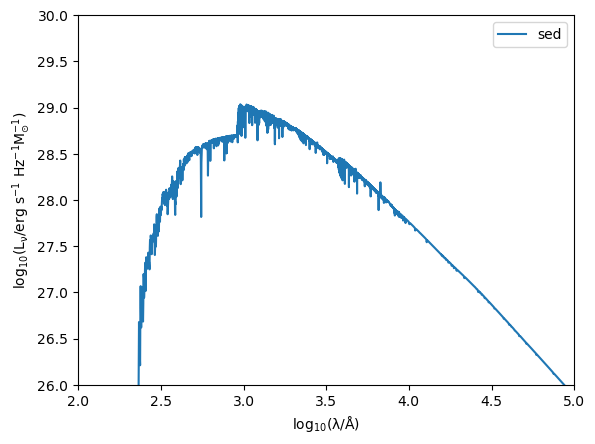

In [15]:
#sed5 = sed + sed
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="sed")
#plt.plot(np.log10(sed5.lam), np.log10(sed5.lnu), label="sed5")
plt.ylim(26, 30)
plt.xlim(2, 5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

It looks like the SED is set from the grid, so I need to figure out how to integrate camels data and the UVM2 filters

# CAMELS EXAMPLE
Use test cosmological simulation data (from the CAMELS simulations) to generate spectra and calculate photometry.



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from unyt import Myr

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ

In [17]:
# Already defined above but a reminder here:
# Define the grid
#grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_dir = "/Users/am/Documents/CAMELS/camels/synthesizer/data/grids/"
#grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [18]:
# create a galaxy from our snapshot data
#gals = load_CAMELS_IllustrisTNG(
#    "../../synthesizer/tests/data/",
#    snap_name="snap_000.hdf5",
#    fof_name="fof_subhalo_tab_000.hdf5",
#)
print(gals)
len(gals)

[<synthesizer.particle.galaxy.Galaxy object at 0x103797d30>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2460>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f20a0>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2340>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f22b0>, <synthesizer.particle.galaxy.Galaxy object at 0x1037f2670>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c040>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cfd0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cbe0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561cb20>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c3a0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c130>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c850>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c9d0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c4f0>, <synthesizer.particle.galaxy.Galaxy object at 0x12561c4c0>, <synthesizer.particle.galaxy.Galaxy obj

10830

In [19]:
g = gals[1]
print(g)

this creates gals, which is a list containing a synthesizer.Galaxy object for each structure in the subfind file. These Galaxy objects contain lots of useful methods for acting on galaxies, in addition to the component parts of a galaxy. These components include Stars, Gas, and BlackHoles. To generate the intrinsic spectrum of the stellar component we can do the following.



In [20]:
#g = gals[1]
#spec = g.stars.get_spectra_stellar(grid)
# Here we grab a single galaxy, and call stars.get_spectra_incident, providing our grid object as the first argument. 
# This returns the spectra as an Sed object (see the SED docs).
# In this case we only have STELLAR spectra so cannot use get_spectra_incident so lets create an SED object using this method instead:

grid_point = grid.get_grid_point((log10age, metallicity))
print(grid_point)

spectra_id = "incident"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

print(sed)

# notice at this point we haven't used gals object at all - this is all the grid.

(19, 3)
----------
SUMMARY OF SED 
Number of wavelength points: 13216 
Wavelength range: [5.60 Å,             360000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.03 
log10(Bolometric luminosity/erg/s):36.56718168296019----------


In [21]:
# continue following tutorial
spec = sed
print(spec)

----------
SUMMARY OF SED 
Number of wavelength points: 13216 
Wavelength range: [5.60 Å,             360000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.03 
log10(Bolometric luminosity/erg/s):36.56718168296019----------


In [22]:
# To access the luminosity and wavelength for _spec we can now do
# Notice that these are unyt arrays with associated units. 
spec.lam[:10], spec.lnu[:10] # this is taken from the grid not the galaxy


(unyt_array([ 5.5999999 ,  6.5       ,  7.4000001 ,  8.30000019,  9.19999981,
        10.1000004 , 11.        , 11.8999996 , 12.8000002 , 13.6999998 ], 'Å'),
 unyt_array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 'erg/(Hz*s)'))

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

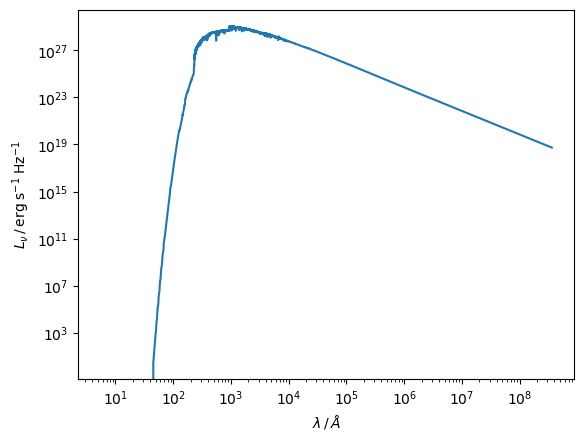

In [23]:
# To plot the spectra manually we can do the following.
plt.loglog(spec.lam, spec.lnu)
plt.xlabel("$\lambda \,/\, \\AA$")
plt.ylabel("$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$")


In [24]:
type(g)

synthesizer.particle.galaxy.Galaxy

In [25]:
print(dir(g.stars))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ages', '_check_part_args', '_check_star_args', '_check_young_old_units', '_coordinates', '_current_masses', '_get_masks', '_initial_masses', '_masses', '_power_law_sample', '_prepare_sed_args', '_prepare_sfzh_args', '_smoothing_lengths', '_softening_lengths', '_velocities', 'ages', 'alpha_enhancement', 'attrs', 'convert_to_comoving_properties', 'convert_to_physical_properties', 'coordinates', 'current_masses', 'generate_line', 'generate_lnu', 'generate_particle_line', 'generate_particle_lnu', 'get_line_attenuated', 'get_line_intrinsic', 'get_line_screen', 'get_particle_line_attenuated', 'get_particle_line_intrinsic', 'get_particle_line_screen', 

In [26]:

# Example: Assuming the spectra are stored in an attribute named 'spectra'
spectra = g.stars.spectra
print(spectra)
# spectra is empty


{}


In [27]:
spectra_incident = g.stars.get_spectra_incident
print(spectra_incident)


<bound method StarsComponent.get_spectra_incident of <synthesizer.particle.stars.Stars object at 0x1037f2370>>


g = gals[1]
spec = g.stars.get_spectra_incident(grid)

In [28]:
print(grid)


------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [29]:
# Use code from create_gals to get particle galaxy data:
from unyt import Myr
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
# Define the metallicity history
zh = ZDist.DeltaConstant(metallicity=0.01)
zh 

# Define the star formation history
sfh_p = {"duration": 100 * Myr}
sfh = SFH.Constant(duration=100 * Myr)
sfh



# Initialise the parametric Stars object
param_stars = ParametricStars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=zh,
    initial_mass=10**9,
)
param_stars


# Define the number of stellar particles we want
n = 10000

# Sample the parametric SFZH, producing a particle Stars object
# we will also pass some keyword arguments for some example attributes
part_stars = sample_sfhz(
    sfzh=param_stars.sfzh,
    log10ages=param_stars.log10ages,
    log10metallicities=param_stars.log10metallicities,
    nstar=n,
    current_masses=np.full(n, 10**8.7 / n),
    redshift=1,
    initial_mass=10**6,
)
print(part_stars)

----------
SUMMARY OF STAR PARTICLES
N_stars: 10000
log10(total mass formed/Msol):  10.00
median(age/Myr): 50.0 yr
----------


In [30]:
from synthesizer import galaxy

# Get a particle galaxy
part_gal = galaxy(stars=part_stars, gas=None, black_holes=None, redshift=1)
print(type(part_gal))
print(part_gal)

<class 'synthesizer.particle.galaxy.Galaxy'>


In [31]:
from synthesizer.particle import Galaxy

# Get a particle galaxy
part_gal2 = Galaxy(stars=part_stars, gas=None, black_holes=None, redshift=1)
print(type(part_gal2))
print(part_gal2)

<class 'synthesizer.particle.galaxy.Galaxy'>


In [32]:
# Import Filters from SVO

lams_xmm = np.linspace(1883.78, 2994.45, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_XMM = Filter("XMM/OM.UVM2", new_lam=lams_xmm)
# filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
filter_codes = ["XMM/OM.UVM2"] 
svo_fil_xmm = FilterCollection(filter_codes=filter_codes, new_lam=lams_xmm)

# now get for UVOT

lams_uvot = np.linspace(1699.08, 2964.30, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2", new_lam=lams_xmm)

filter_codes = ["Swift/UVOT.UVM2"] 
svo_fil_uvot = FilterCollection(filter_codes=filter_codes, new_lam=lams_uvot)

filt_lst = [fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=lams_xmm
)
# Loop over them:
print("My Filters:")
for f in combined_filters:
    print(f.filter_code)



My Filters:
Swift/UVOT.UVM2
XMM/OM.UVM2


In [36]:
photo_lums = g.get_photo_luminosities(combined_filters["XMM/OM.UVM2"])
print(photo_lums)


None


In [37]:
print("Stellar luminosities available:", list(g.stars.photo_luminosities.keys()))


Stellar luminosities available: []


 You don't make galaxies from a grid, you make a grid object. From the camels data you make galaxy objects. You combine these to produce spectra for a given galaxy

In [38]:
g = gals[1]
spec = g.stars.get_spectra_incident(grid) # Try new grid from Chris.

In [39]:
print(spec)

----------
SUMMARY OF SED 
Number of wavelength points: 13216 
Wavelength range: [5.60 Å,             360000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             28.97 
log10(Bolometric luminosity/erg/s):44.453868752862824----------


In [40]:
spec.lam[:10], spec.lnu[:10]


(unyt_array([ 5.5999999 ,  6.5       ,  7.4000001 ,  8.30000019,  9.19999981,
        10.1000004 , 11.        , 11.8999996 , 12.8000002 , 13.6999998 ], 'Å'),
 unyt_array([1.13419935e-02, 6.96210021e-01, 2.96070369e+01, 5.87992388e+02,
        9.16576748e+03, 1.23829224e+05, 1.31708803e+06, 1.04562426e+07,
        6.10081169e+07, 2.64077144e+08], 'erg/(Hz*s)'))

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

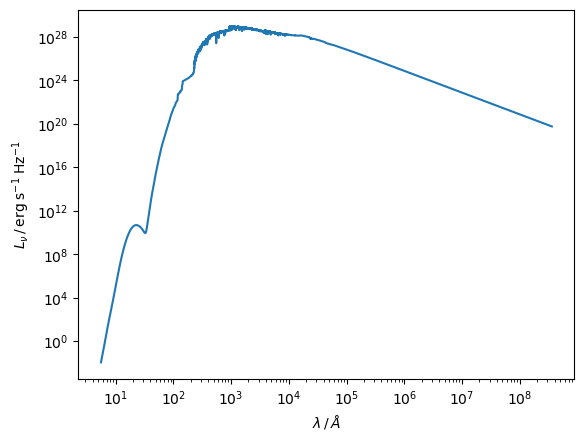

In [41]:
plt.loglog(spec.lam, spec.lnu)
plt.xlabel("$\lambda \,/\, \\AA$")
plt.ylabel("$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$")

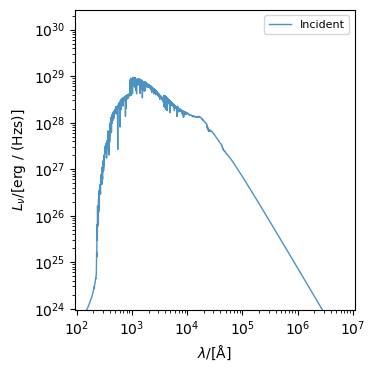

In [42]:
g.stars.plot_spectra()
plt.show()

In [43]:
spec.get_fnu0()
# rest flux from the sed

unyt_array([9.47934737e-11, 5.81874487e-09, 2.47448024e-07, ...,
       2.43712583e+12, 1.08316769e+12, 4.81408131e+11], 'nJy')

In [44]:
# broadband luminosity from the filter collection combined_filters
print("filter collections: ", combined_filters)


# UVJ - Helper function to produce a FilterCollection containing UVJ tophat filters.
fc = UVJ(new_lam=grid.lam)


'''Args:
    new_lam (array-like, float)
        The wavelength array for which each filter's transmission curve is defined.

Returns:
    FilterCollection
        A FilterCollection containing top hat UVJ filters.
'''
_UVJ = spec.get_photo_fluxes(fc)
print(_UVJ)



filter collections:  <synthesizer.filters.FilterCollection object at 0x1037f2430>
--------------------------------------------------
|               PHOTOMETRY (FLUX)                |
|--------------------|---------------------------|
| U (λ = 3.65e+03 Å) | 2.87e+20 erg/(Hz*cm**2*s) |
|--------------------|---------------------------|
| V (λ = 5.50e+03 Å) | 2.09e+20 erg/(Hz*cm**2*s) |
|--------------------|---------------------------|
| J (λ = 1.22e+04 Å) | 1.18e+20 erg/(Hz*cm**2*s) |
--------------------------------------------------



# Young and old stellar populations
We restrict the age of star particles used for calculating the spectra. The age is specified by the young and old parameters; these default to None, but if set to a value of age (in units of Myrs) they will filter the star particles above or below this value. If both young and old are set, the code will raise an error.

In [ ]:
young_spec = g.stars.get_spectra_incident(grid, young=100 * Myr)
old_spec = g.stars.get_spectra_incident(grid, old=100 * Myr)

plt.loglog(young_spec.lam, young_spec.lnu, label="young")
plt.loglog(old_spec.lam, old_spec.lnu, label="old")
plt.legend()
plt.xlabel("$\lambda \,/\, \\AA$")
plt.ylabel("$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$")

# Dust attenuation
We can apply a range of different dust models to our intrinsic spectra. get_spectra_screen applies a simple dust screen to all stellar particles, assuming a V band optical depth $\tau_{V}$


In [ ]:
spec = g.stars.get_spectra_screen(grid, tau_v=0.33)
fig, ax = g.stars.plot_spectra(spectra_to_plot=["intrinsic", "emergent"])
plt.show()

get_spectra_CharlotFall applies the Charlot & Fall+00 two component dust screen model, with V band attenuation for young and old populations defined by the $\tau_{V}^{BC}$ and $\tau_{V}^{ISM}$ 


In [ ]:
spec = g.stars.get_spectra_CharlotFall(grid, tau_v_ISM=0.33, tau_v_BC=0.67)
fig, ax = g.stars.plot_spectra(spectra_to_plot=["intrinsic", "emergent"])
plt.show()

# Multiple galaxies
If we want to create spectra for multiple galaxies we can use a list comprehension. Here we grab the luminosity lnu of each galaxy into a list, and combine into a single sed object afterwards using the grid wavelength.

In [ ]:
specs = np.vstack([g.stars.get_spectra_incident(grid).lnu for g in gals])
specs = Sed(lam=grid.lam, lnu=specs)

Importantly here, we don’t create an SED object for each galaxy spectra. We instead create the 2D array of spectra, and then create an Sed object for the whole collection.



In [ ]:
fig, ax = plt.subplots(1, 1)
ax.loglog(grid.lam, specs.lnu.T)
ax.set_ylim(
    1e22,
)
ax.set_xlim(1e2, 2e4)
ax.set_xlabel("$\lambda \,/\, \\AA$")
ax.set_ylabel("$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$")

# Calculate broadband luminosities
We can then use the Sed methods on the whole collection. This is much faster than calling the method for each spectra individually, since we can take advantage of vectorisation. For example, we can calculate UVJ colours of all the selected galaxies in just a couple of lines.

First get rest frame ‘flux’

In [ ]:
spec.get_fnu0()


--------------------------------------------------
|               PHOTOMETRY (FLUX)                |
|--------------------|---------------------------|
| U (λ = 3.65e+03 Å) | 2.87e+20 erg/(Hz*cm**2*s) |
|--------------------|---------------------------|
| V (λ = 5.50e+03 Å) | 2.09e+20 erg/(Hz*cm**2*s) |
|--------------------|---------------------------|
| J (λ = 1.22e+04 Å) | 1.18e+20 erg/(Hz*cm**2*s) |
--------------------------------------------------

erg/(Hz*cm**2*s)


(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{Å}]$', ylabel='$F/[\\mathrm{erg\\ / \\ (Hz\\ cm^2\\ s)}]$'>)

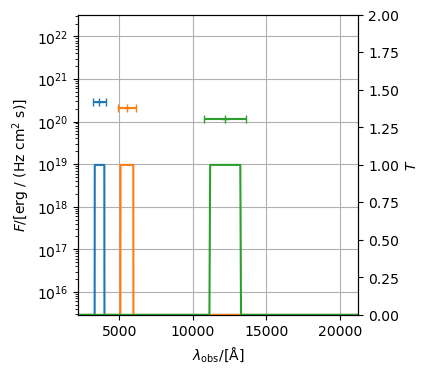

In [45]:
# Define a filter collection object (UVJ default) and calculate the photometry.

fc = UVJ(new_lam=grid.lam)

_UVJ = spec.get_photo_fluxes(fc)
print(_UVJ)
_UVJ.plot_photometry(show=True)

----------------------------------------------------------------
|                      PHOTOMETRY (FLUX)                       |
|----------------------------------|---------------------------|
| Swift/UVOT.UVM2 (λ = 2.25e+03 Å) | 4.84e+20 erg/(Hz*cm**2*s) |
|----------------------------------|---------------------------|
|   XMM/OM.UVM2 (λ = 2.33e+03 Å)   | 4.68e+20 erg/(Hz*cm**2*s) |
----------------------------------------------------------------

erg/(Hz*cm**2*s)


(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{Å}]$', ylabel='$F/[\\mathrm{erg\\ / \\ (Hz\\ cm^2\\ s)}]$'>)

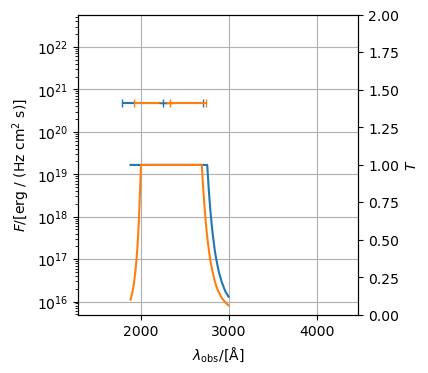

In [46]:
# do same for UVM2
_UVM2 = spec.get_photo_fluxes(combined_filters)
print(_UVM2)
_UVM2.plot_photometry(show=True)

In [55]:
# do same for UVM2
_UVM2 = gals.get_spectra(combined_filters)
print(_UVM2)
_UVM2.plot_photometry(show=True)

AttributeError: 'numpy.ndarray' object has no attribute 'get_spectra'

In [51]:
spec_uvm2 = g.stars.get_spectra_incident(combined_filters) # Try new grid from Chris.



AttributeError: 'FilterCollection' object has no attribute 'spectra'

/var/folders/yn/_ch1_n7x7y1g91hrx1ljp5n80000gp/T/ipykernel_5268/4033077821.py:3: RuntimeWarning: divide by zero encountered in log10
  mstar = np.log10(


ValueError: 'c' argument has 10830 elements, which is inconsistent with 'x' and 'y' with size 1.

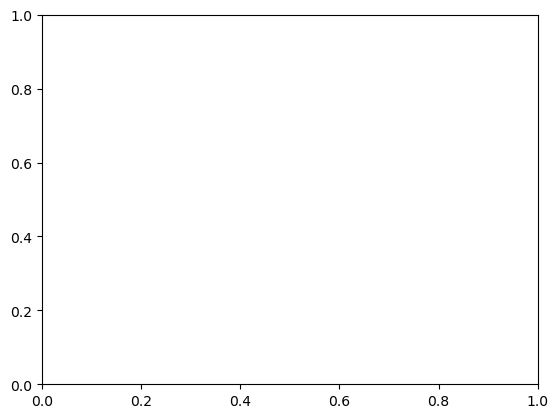

In [49]:
# Do for multiple, plot UVJ diagram, coloured by $M_{*}$

mstar = np.log10(
    np.array([np.sum(g.stars.initial_masses) for g in gals]) * 1e10
)
spec.get_fnu0()
_UVJ = spec.get_photo_fluxes(fc)

UV = _UVJ["U"] / _UVJ["V"]
VJ = _UVJ["V"] / _UVJ["J"]

plt.scatter(VJ, UV, c=mstar, s=40)
plt.xlabel("VJ")
plt.ylabel("UV")
plt.colorbar(label="$\mathrm{log_{10}} \, M_{\star} \,/\, \mathrm{M_{\odot}}$")

In [52]:
# Survey Example
from synthesizer.survey import Survey
# Set up a filter collection object (UVJ default)
# and we have combined_filters
fc = UVJ(new_lam=grid.lam)
fc_2 = combined_filters

# Convert gals to an array
gals = np.array(gals)

# Create an empty Survey object
survey1 = Survey(super_resolution_factor=1)
survey2 = Survey(super_resolution_factor=1)

# Let’s add the filters to an instrument in the survey
survey1.add_photometric_instrument(filters=fc, label="UVJ")
survey2.add_photometric_instrument(filters=fc_2, label="UVM2")

# Store the galaxies in the survey
survey1.add_galaxies(gals)
survey2.add_galaxies(gals)

In [ ]:
survey1

In [56]:
survey2

AttributeError: 'Survey' object has no attribute 'gals'